In [3]:
from __future__ import division
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

sns.set_style('darkgrid')

1. Preparing data

In [4]:
! pip install geopandas

In [6]:
data = pd.read_csv('/listings (1).csv')

print('Number of features: %s' %data.shape[1])
print('Number of examples: %s' %data.shape[0])

Number of features: 16
Number of examples: 10272


In [7]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2265,Zen-East in the Heart of Austin (monthly rental),2466,Paddy,NaN,78702,30.27750,-97.71398,Entire home/apt,200,7,24,2019-03-16,0.17,3,131
1,5245,"Eco friendly, Colorful, Clean, Cozy monthly share",2466,Paddy,NaN,78702,30.27577,-97.71379,Private room,114,30,9,2018-03-14,0.06,3,0
2,5456,"Walk to 6th, Rainey St and Convention Ctr",8028,Sylvia,NaN,78702,30.26112,-97.73448,Entire home/apt,104,2,543,2021-02-01,3.74,1,354
3,5636,"Soco, Barton Springs Private Guest Cottage",7148,Peggy,NaN,78704,30.24630,-97.76361,Entire home/apt,46,30,21,2020-11-06,0.15,2,67
4,5769,NW Austin Room,8186,Elizabeth,NaN,78729,30.45697,-97.78422,Private room,39,1,259,2021-02-10,1.96,1,79


# New Section

In [10]:
# I want to describe only columns which contain numerical values

data.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'last_review'], axis=1).describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,10272.000000,10272.000000,10272.000000,10272.000000,10272.000000,7672.000000,10272.000000,10272.000000
mean,30.281591,-97.752913,255.656542,8.240654,31.720600,1.280021,19.581192,122.290401
std,0.061041,0.058415,513.284268,23.416609,68.107864,1.697720,67.081990,138.467978
min,30.078870,-98.056630,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,30.245163,-97.770485,82.000000,1.000000,0.000000,0.160000,1.000000,0.000000
50%,30.270175,-97.745035,136.000000,2.000000,5.000000,0.650000,1.000000,59.000000
75%,30.305237,-97.721430,250.000000,3.000000,29.000000,1.790000,4.000000,263.250000
max,30.515280,-97.560620,16264.000000,999.000000,951.000000,34.030000,358.000000,365.000000


In [11]:
# Printing unique values for string columns

for col in data[['neighbourhood_group', 'neighbourhood', 'room_type']]:
    print('Unique values in column: %s' %col)
    print(data[col].unique()), '\n'

Unique values in column: neighbourhood_group
[nan]
Unique values in column: neighbourhood
[78702 78704 78729 78759 78741 78703 78757 78727 78731 78758 78744 78705
 78722 78725 78701 78751 78723 78752 78736 78732 78746 78745 78754 78730
 78724 78753 78756 78749 78735 78721 78734 78739 78733 78737 78748 78738
 78726 78717 78750 78728 78712 78742 78747 78719]
Unique values in column: room_type
['Entire home/apt' 'Private room' 'Hotel room' 'Shared room']


2. Null values

In [12]:
print('Null values in Airbnb dataset: \n')
print(data.isnull().sum())
print('\n')
print('Percentage of null values in review columns: ')
print(round(data['last_review'].isnull().sum()/len(data)*100, 2),"%")

# For reviews there are many null values so i want to also see percentage to the whole dataset
# Null values in name, host_name, last_review, reviews_per_month, which for reviews is the same amount. 
# I want to see if it is for the same rows
# I want to see also how null values for name and host_name are distributed because these amounts are different

Null values in Airbnb dataset: 

id                                    0
name                                  0
host_id                               0
host_name                             5
neighbourhood_group               10272
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                        2600
reviews_per_month                  2600
calculated_host_listings_count        0
availability_365                      0
dtype: int64


Percentage of null values in review columns: 
25.31 %


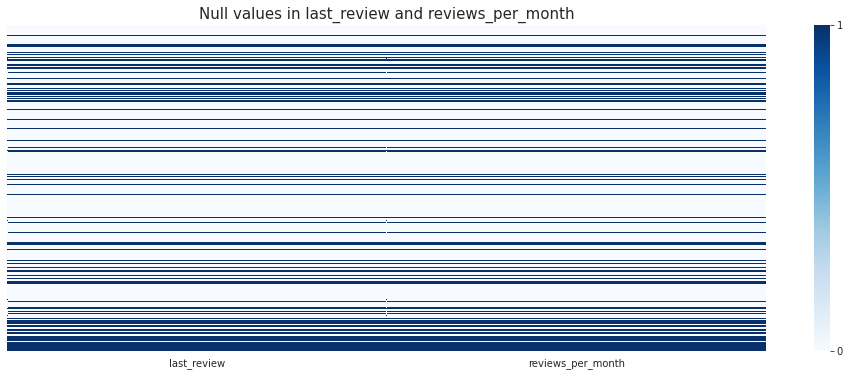

In [13]:
fig, ax = plt.subplots(figsize=(17,6))
plt.title('Null values in last_review and reviews_per_month', fontsize=15)
sns.heatmap(data[['last_review','reviews_per_month' ]].isnull(), cmap="Blues", yticklabels=False, ax=ax, cbar_kws={'ticks': [0, 1]})

In [14]:
null_name = (pd.DataFrame(np.where((data['name'].isnull())))).transpose()
null_host_name = (pd.DataFrame(np.where((data['host_name'].isnull())))).transpose()

sum_null = pd.concat([null_name,null_host_name], axis=1, ignore_index=True)
sum_null.columns = ['Null rows in name', 'Null rows in host_name']
sum_null

# Null values in name and host_name columns are accidental

,Null rows in name,Null rows in host_name
0,NaN,13
1,NaN,991
2,NaN,1714
3,NaN,5266
4,NaN,8133


In [15]:
# last_review column may be dropped

data.drop('last_review', axis=1, inplace=True)

In [16]:
# Null values for name and host_name I replace with 0. Also reviews_per_month I replace with 0

data['name'].fillna(value=0, inplace=True)

In [17]:
data['host_name'].fillna(value=0, inplace=True)

In [18]:
data['reviews_per_month'].fillna(value=0, inplace=True)

In [19]:
data.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group               10272
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [20]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2265,Zen-East in the Heart of Austin (monthly rental),2466,Paddy,NaN,78702,30.27750,-97.71398,Entire home/apt,200,7,24,0.17,3,131
1,5245,"Eco friendly, Colorful, Clean, Cozy monthly share",2466,Paddy,NaN,78702,30.27577,-97.71379,Private room,114,30,9,0.06,3,0
2,5456,"Walk to 6th, Rainey St and Convention Ctr",8028,Sylvia,NaN,78702,30.26112,-97.73448,Entire home/apt,104,2,543,3.74,1,354
3,5636,"Soco, Barton Springs Private Guest Cottage",7148,Peggy,NaN,78704,30.24630,-97.76361,Entire home/apt,46,30,21,0.15,2,67
4,5769,NW Austin Room,8186,Elizabeth,NaN,78729,30.45697,-97.78422,Private room,39,1,259,1.96,1,79


3. Evaluations

In [21]:
# Evaluation 1 - top 3 hosts; hosts with the biggest amount of listings

top_3_hosts = (pd.DataFrame(data.host_id.value_counts())).head(3)
top_3_hosts.columns=['Listings']
top_3_hosts['host_id'] = top_3_hosts.index
top_3_hosts.reset_index(drop=True, inplace=True)
top_3_hosts

,Listings,host_id
0,358,359036978
1,131,104309976
2,82,109638288


In [22]:
# Evaluation 2 - top 3 the hottest neighbourhoood groups

top_3_neigh = pd.DataFrame(data['neighbourhood_group'].value_counts().head(3))
top_3_neigh.columns=['Listings']
top_3_neigh['Neighbourhood Group'] = top_3_neigh.index
top_3_neigh.reset_index(drop=True, inplace=True)
top_3_neigh

,Listings,Neighbourhood Group


In [23]:
# Evaluation 3 - average price, availability in year 

average_price_ava = pd.DataFrame(data[['price', 'availability_365']].describe())
average_price_ava.columns=['Price', 'Availability in a year']
average_price_ava

,Price,Availability in a year
count,10272.000000,10272.000000
mean,255.656542,122.290401
std,513.284268,138.467978
min,0.000000,0.000000
25%,82.000000,0.000000
50%,136.000000,59.000000
75%,250.000000,263.250000
max,16264.000000,365.000000


In [24]:
# Evaluation 4 - most reviewed hosts

rev_group = pd.DataFrame(data.groupby('number_of_reviews').sum()['host_id'])
most_reviewed = (rev_group.sort_values('number_of_reviews',ascending=False)).head(3)
most_reviewed.columns = ['Host ID']
most_reviewed['Number of reviews'] = most_reviewed.index
most_reviewed.reset_index(drop=True, inplace=True)
most_reviewed

,Host ID,Number of reviews
0,5620519,951
1,5152543,870
2,740347,869


In [25]:
# Evaluation 5 - the most reviewed hosts per month

gr = pd.DataFrame(data.groupby('reviews_per_month').sum()['host_id'])
rev = (gr.sort_values('reviews_per_month',ascending=False)).head(3)
rev.columns = ['Host ID']
rev['Reviews per month'] = rev.index
rev.reset_index(drop=True, inplace=True)
rev

,Host ID,Reviews per month
0,379711454,34.03
1,379711454,17.67
2,379711454,14.29


In [26]:

# Evaluation 6 - prices in every neighbourhood group

# Brooklyn
nei1 = data.loc[data['neighbourhood_group'] == 'Brooklyn']
price_nei1 = nei1[['price']]
# Manhattan
nei2 = data.loc[data['neighbourhood_group'] == 'Manhattan']
price_nei2 = nei2[['price']]
# Queens
nei3 = data.loc[data['neighbourhood_group'] == 'Queens']
price_nei3 = nei3[['price']]
# Staten Island
nei4 = data.loc[data['neighbourhood_group'] == 'Staten Island']
price_nei4 = nei4[['price']]
# Bronx
nei5 = data.loc[data['neighbourhood_group'] == 'Bronx']
price_nei5 = nei5[['price']]

price_list = [price_nei1, price_nei2, price_nei3, price_nei4, price_nei5]



price_stats = []
nei_list = ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']

# price statistics for every neighbourhood

for x in price_list:
    i = x.describe(percentiles=[.25, .5, .75])
    i = i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index': 'Stats'}, inplace=True)
    price_stats.append(i)

price_stats[0].rename(columns={'price': nei_list[0]}, inplace=True)
price_stats[1].rename(columns={'price': nei_list[1]}, inplace=True)
price_stats[2].rename(columns={'price': nei_list[2]}, inplace=True)
price_stats[3].rename(columns={'price': nei_list[3]}, inplace=True)
price_stats[4].rename(columns={'price': nei_list[4]}, inplace=True)

# final view of dataframe

stats_df = price_stats
stats_df = [df.set_index('Stats') for df in stats_df]
stats_df=stats_df[0].join(stats_df[1:])
stats_df

,Brooklyn,Manhattan,Queens,Staten Island,Bronx
Stats,,,,,
min,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN


4. Visualisations

IndexError: ignored

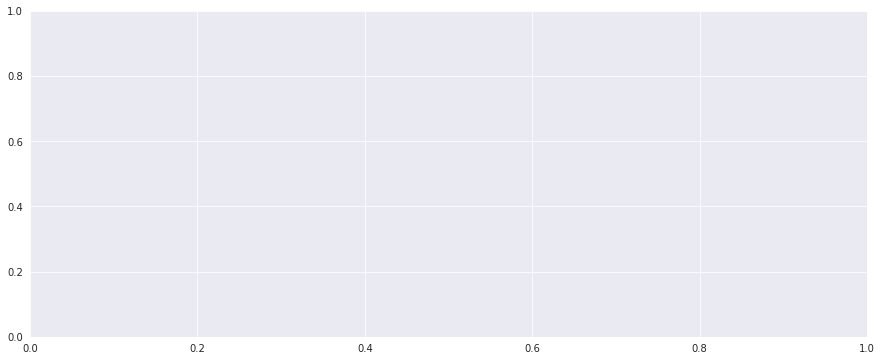

In [27]:
# Visualisation 1 - Neighbourhood groups with counts with category room_type

plt.figure(figsize=(15,6))
sns.countplot(data=data, x='neighbourhood_group', hue='room_type', palette='GnBu_d')
plt.title('Counts of airbnb in neighbourhoods with room type category', fontsize=15)
plt.xlabel('Neighbourhood group')
plt.ylabel("Count")
plt.legend(frameon=False, fontsize=12)

In [28]:
# Visualisation 2 - distribution of prices

plt.figure(figsize=(15,6))
sns.violinplot(data=data[data.price <500], x='neighbourhood_group', y='price', palette='GnBu_d')
plt.title('Density and distribution of prices for each neighbourhood group', fontsize=15)
plt.xlabel('Neighbourhood group')
plt.ylabel("Price")

ValueError: ignored

<Figure size 1080x432 with 0 Axes>

In [29]:
# Visualisation 3 - top neighbourhoods with category of room type

top_nei = data['neighbourhood'].value_counts().reset_index().head(10)
top_nei = top_nei['index'].tolist()

plt.figure(figsize=(15,6))
vis_3 = sns.catplot(x='neighbourhood', hue='neighbourhood_group', col='room_type', data=data.loc[data['neighbourhood'].isin(top_nei)], kind='count', palette='GnBu_d')
vis_3.set_xticklabels(rotation=90)

ValueError: ignored

<Figure size 1080x432 with 0 Axes>

Text(0, 0.5, 'Count')

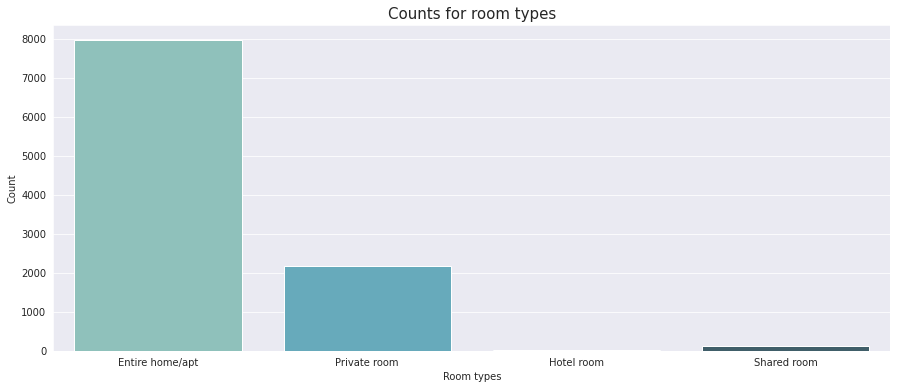

In [30]:
# Visualisation 4 - room types

plt.figure(figsize=(15,6))
sns.countplot(data=data, x='room_type', palette='GnBu_d')
plt.title('Counts for room types', fontsize=15)
plt.xlabel('Room types')
plt.ylabel("Count")

Text(0, 0.5, 'Frequency')

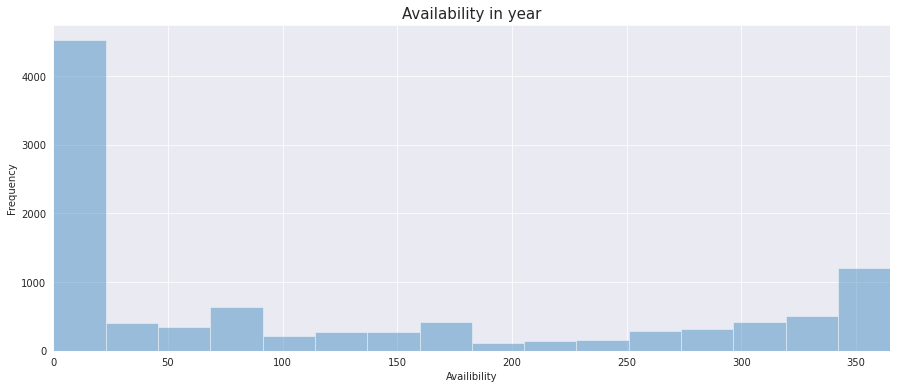

In [31]:
# Visualisation 5 - availability in year

plt.figure(figsize=(15,6))
sns.distplot(data.availability_365, kde=False)
plt.xlim(0,365)
plt.title('Availability in year', fontsize=15)
plt.xlabel('Availibility')
plt.ylabel("Frequency")

No handles with labels found to put in legend.


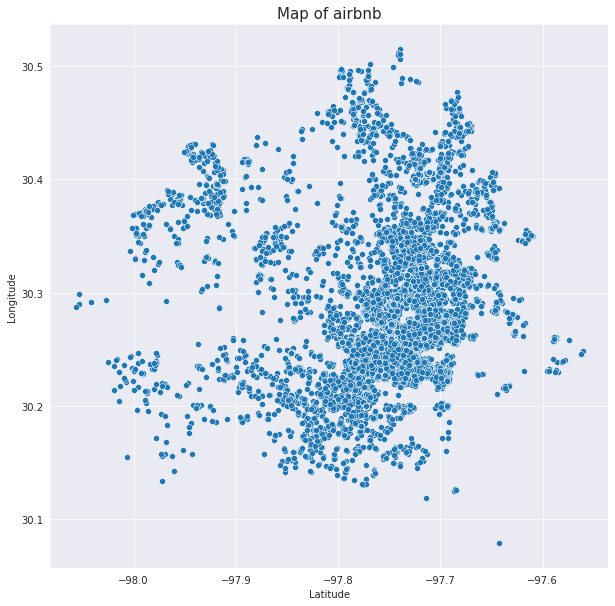

In [32]:
# Visualisation 6 - map of hosts

plt.figure(figsize=(10,10))
a = sns.scatterplot(data=data, x='longitude', y='latitude', hue='neighbourhood_group', palette='GnBu_d')
plt.title('Map of airbnb', fontsize=15)
plt.xlabel('Latitude')
plt.ylabel("Longitude")
plt.legend(frameon=False, fontsize=13)

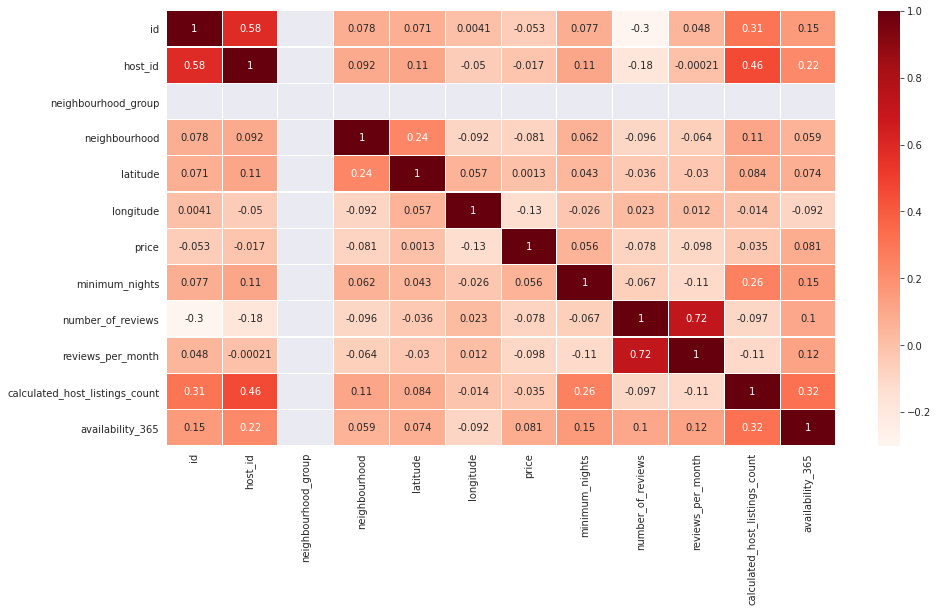

In [33]:
# Visualisation 7 - correlations between values

plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot=True, linewidths=0.1, cmap='Reds')

In [34]:
# Visualisation 8 - prices in neighbourhoods 

data1 = pd.DataFrame(data.groupby(['neighbourhood_group', 'neighbourhood'])['price'].mean())
data1.reset_index(inplace=True)

bronx = (data1[data1['neighbourhood_group'] =='Bronx']).sort_values(by='price',ascending=False).head(10)
brooklyn = (data1[data1['neighbourhood_group'] =='Brooklyn']).sort_values(by='price',ascending=False).head(10)
manhattan = (data1[data1['neighbourhood_group'] =='Manhattan']).sort_values(by='price',ascending=False).head(10)
queens = (data1[data1['neighbourhood_group'] =='Queens']).sort_values(by='price',ascending=False).head(10)
staten = (data1[data1['neighbourhood_group'] =='Staten Island']).sort_values(by='price',ascending=False).head(10)

neighs = [bronx, brooklyn, manhattan, queens, staten]
titles = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

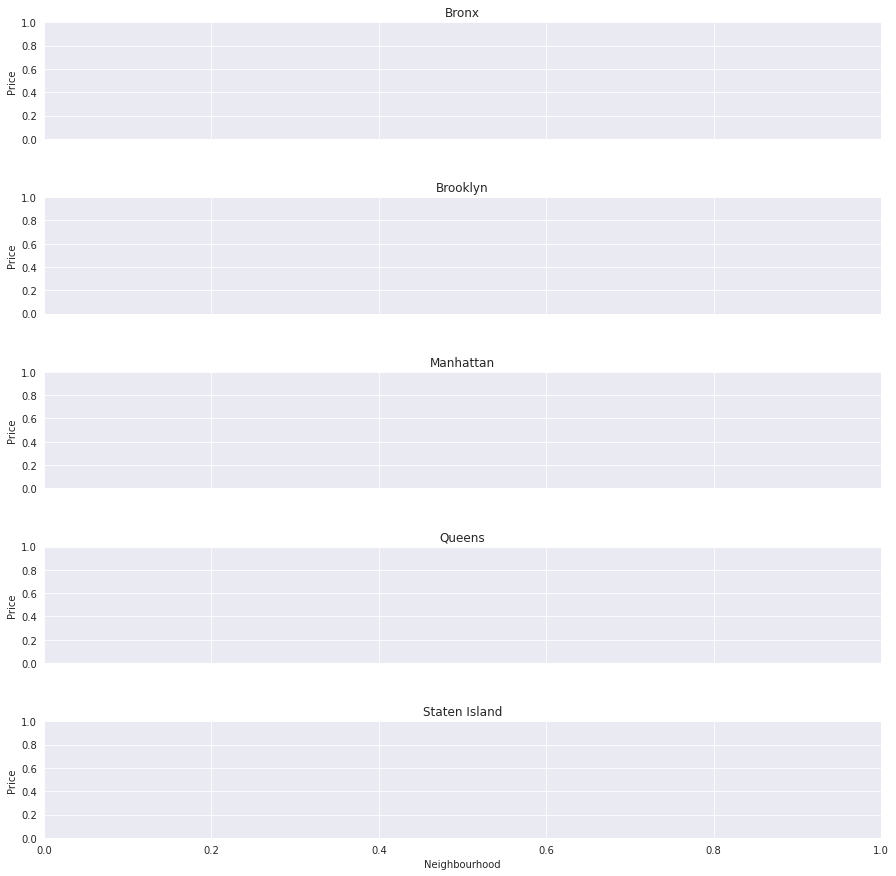

In [35]:
fig, axs = plt.subplots(5, figsize=(15, 15), gridspec_kw={'hspace': 0.5, 'wspace': 0})
sns.scatterplot(data=bronx, x='neighbourhood', y='price', ax=axs[0], color='red', s=100)
sns.scatterplot(data=brooklyn, x='neighbourhood', y='price', ax=axs[1], color='blue', s=100)
sns.scatterplot(data=manhattan, x='neighbourhood', y='price', ax=axs[2], color='black', s=100)
sns.scatterplot(data=queens, x='neighbourhood', y='price', ax=axs[3], color='green', s=100)
sns.scatterplot(data=staten, x='neighbourhood', y='price', ax=axs[4], color='purple', s=100)

axs[0].set_title('Bronx')
axs[1].set_title('Brooklyn')
axs[2].set_title('Manhattan')
axs[3].set_title('Queens')
axs[4].set_title('Staten Island')

for ax in axs:
    ax.set(xlabel='Neighbourhood', ylabel='Price')
    ax.label_outer()

5. Predictions

In [36]:
# Preparing dataset for predictions

data_pred = pd.read_csv('../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')

FileNotFoundError: ignored

In [37]:
data_pred.head()

NameError: ignored

In [38]:
data_pred.drop(['name', 'host_name', 'last_review', 'id'], inplace=True, axis=1)

NameError: ignored

In [39]:
data_pred['reviews_per_month'] = data_pred['reviews_per_month'].fillna(value=0, inplace=False)

NameError: ignored

In [40]:
data_pred.head()

NameError: ignored

In [41]:
le = preprocessing.LabelEncoder()

le.fit(data_pred['neighbourhood_group'])
data_pred['neighbourhood_group']=le.transform(data_pred['neighbourhood_group'])

le.fit(data_pred['neighbourhood'])
data_pred['neighbourhood']=le.transform(data_pred['neighbourhood'])

le.fit(data_pred['room_type'])
data_pred['room_type']=le.transform(data_pred['room_type'])

NameError: ignored

In [42]:
data_pred.sort_values('price', ascending=True, inplace=True)

NameError: ignored

In [43]:
data_pred = data_pred[11:-6]

NameError: ignored

In [ ]:
lm = LinearRegression()

In [44]:
X = data_pred.drop(['price', 'longitude'], inplace=False, axis=1)
y = data_pred['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

lm.fit(X_train, y_train)

NameError: ignored

In [45]:
predictions = lm.predict(X_test)

NameError: ignored

In [46]:
# Evaluated metrics

mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
r2 = metrics.r2_score(y_test, predictions)

print('MAE (Mean Absolute Error): %s' %mae)
print('MSE (Mean Squared Error): %s' %mse)
print('RMSE (Root mean squared error): %s' %rmse)
print('R2 score: %s' %r2)

NameError: ignored

In [47]:
# Avtual vs predicted values

error = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': predictions.flatten()})
error.head(10)

NameError: ignored

NameError: ignored

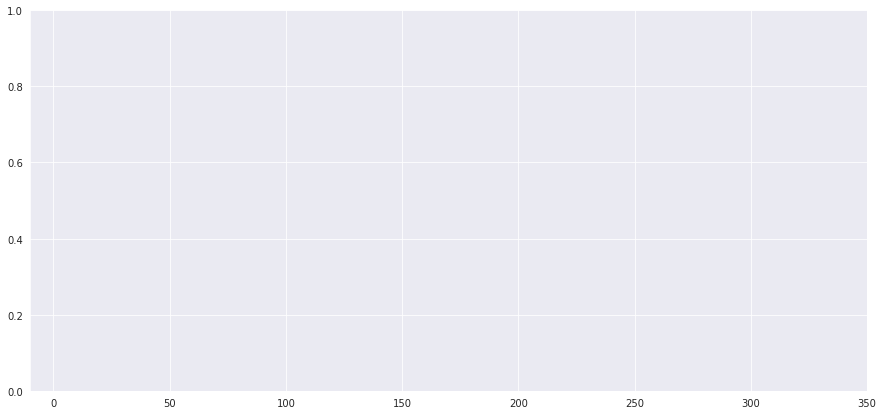

In [48]:
# Evaluated predictions

plt.figure(figsize=(15,7))
plt.xlim(-10,350)
sns.regplot(y=y_test, x=predictions, color='blue')
plt.title('Evaluated predictions', fontsize=15)
plt.xlabel('Predictions')
plt.ylabel('Test')